In [1]:
%load_ext autoreload
%autoreload 2
# %autoreload # reloads modules
# %aimport # lists what it will/won't reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split

from utils import *

### Test multiple classification methods with the original data

In [2]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Clearly feature engineering isn't really an option here since we are dealing with SVD modes.


| Columns       | Description |
|:------------- |:-------------|
| amount        | amount of transaction in cents|
| time          | time of transaction in seconds|
| class         | boolean fraudulent/legitimate-->1/0|
| V\*           | SVD features (US in svd USV')|

In [3]:
fradulent = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

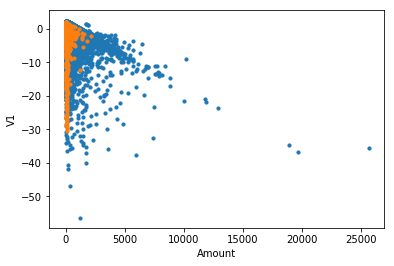

In [4]:
ax = plot_features('Amount','V1',data)
plt.show()

In [5]:
cols = list(data.columns)[1:] # removes time

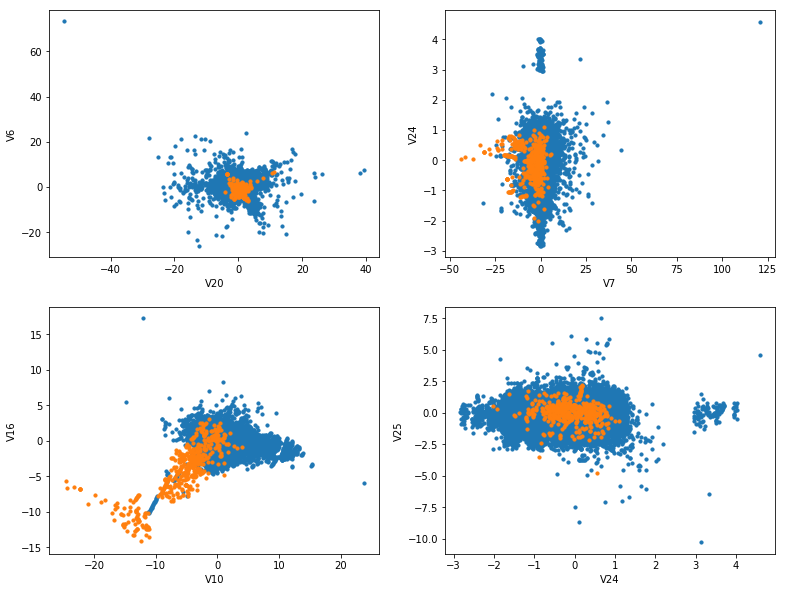

In [6]:
tile_random_features(cols[0:-1], data) # don't plot 'Class'
# list(np.random.choice(col_names, 2, replace=False)) + ['squat']

Data often doesn't look very Gaussian in some dimensions, let's see how gaussian approaches look..

KNN looks like a much more promising approach, granted we alter the cost function to predict the minority class when there are verrry few within the nearest k (maybe 1..). This sounds like a recipe for overfitting however. Perhaps to match this with SMOTE would make for good results.

SVM, or really any linear classifier, looks like it would perform poorly.

#### Prep data

In [7]:
train, test = train_test_split(data, test_size=0.2)

print 'Sanity check:'
print '% of fraud cases in original, train, and test sets:'
print len(fradulent)*1.0/len(data)
print len(train[train['Class']==1])*1.0/len(train)
print len(test[test['Class']==1])*1.0/len(test)

Sanity check:
% of fraud cases in original, train, and test sets:
0.00172748563062
0.00173363470781
0.00170288964573


In [8]:
# Split into features / class labels
class TestTrainSplit:
    def __init__(self, train, test):
#         data.info()
        self.train_x, self.train_y = [df.as_matrix() for df in split_class(train)]
        self.test_x, self.test_y = [df.as_matrix() for df in split_class(test)]
#         self.X, self.y = [df.as_matrix() for df in split_class(data)]

        

In [9]:
n_dims = 15 # some subset of the 28 features in the complete data set
reduce_cols = lambda cols, n: cols[0:n] + cols[-2:]

# use same train/ test to compare dim red to full data
train, test = train_test_split(data, test_size=0.2)
    
full_data = TestTrainSplit(train, test)

cols_reduced = reduce_cols(cols,n_dims)
reduced_data = TestTrainSplit(train[cols_reduced], test[cols_reduced])
reduced_data.X, reduced_data.y = [df.as_matrix() for df in split_class(data[cols_reduced])]

train_x, train_y = full_data.train_x, full_data.train_y
test_x, test_y = full_data.test_x, full_data.test_y
X, y = [df.as_matrix() for df in split_class(data)]

### Implement classification methods

Find the best classifiers for this dataset. Here is where we test any potential algorithm improvements to the class imbalance.

In [10]:
avg_model_scores = {}

#### Gaussian Methods
It seems pretty absurd to use LDA here given that each class must share the same covariance matrix. Based on above plots this seems silly, and basically completely determined by the majority class. Let's try quadratic discriminant analysis instead, plus Naive Bayes. Naive Bayes is like QDA with diagonal covariance matrices, so more restricted

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

name = "QDA"
print name
# qda = QuadraticDiscriminantAnalysis().fit(train_x, train_y)
# print_metrics(test_y, qda.predict(test_x))
test_model(QuadraticDiscriminantAnalysis(), X, y);

name = "Naive Bayes"
print ''
print name
# nb = GaussianNB().fit(train_x, train_y)
# print_metrics(test_y, nb.predict(test_x))
test_model(GaussianNB(), X, y);


QDA
Precision: 	0.06
Recall: 	0.87
F1: 		0.11
Geometric mean: 0.92

Naive Bayes
Precision: 	0.14
Recall: 	0.66
F1: 		0.23
Geometric mean: 0.80


In [12]:
np.unique(y)

array([0, 1])

In [13]:
name = "qda"
print "QDA (n_dims={})".format(n_dims)
avg_model_scores[name] = test_model(QuadraticDiscriminantAnalysis(), reduced_data.X, reduced_data.y)

name = "naive_bayes"
print ''
print "Naive Bayes (n_dims={})".format(n_dims)
avg_model_scores[name] = test_model(GaussianNB(), reduced_data.X, reduced_data.y)

QDA (n_dims=15)
Precision: 	0.06
Recall: 	0.87
F1: 		0.11
Geometric mean: 0.92

Naive Bayes (n_dims=15)
Precision: 	0.08
Recall: 	0.82
F1: 		0.14
Geometric mean: 0.90


Surprisingly QDA actually did pretty well.

#### Decision Tree
Scikit docs:
>Decision trees tend to overfit on data with a large number of features. Getting the right ratio of samples to number of features is important, since a tree with few samples in high dimensional space is very likely to overfit.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

name = "tree"
print name
avg_model_scores[name] = test_model(DecisionTreeClassifier(), reduced_data.X, reduced_data.y, cv=3)

name = 'rand_forest'
print ''
print name
avg_model_scores[name] = test_model(RandomForestClassifier(n_estimators=10), reduced_data.X, reduced_data.y, cv=3)

name = 'tree_entropy'
print ''
print name
avg_model_scores[name] = test_model(DecisionTreeClassifier(criterion='entropy'), reduced_data.X, reduced_data.y, cv=3)

# name = 'tree_balanced'
# print ''
# print name
# test_model(DecisionTreeClassifier(criterion='gini', class_weight='balanced'), reduced_data.X, reduced_data.y, cv=3)
# test_model(DecisionTreeClassifier(criterion='entropy', class_weight='balanced'), reduced_data.X, reduced_data.y, cv=3)
# print ''

tree
Precision: 	0.56
Recall: 	0.77
F1: 		0.63
Geometric mean: 0.87

rand_forest
Precision: 	0.88
Recall: 	0.74
F1: 		0.79
Geometric mean: 0.86

tree_entropy
Precision: 	0.58
Recall: 	0.73
F1: 		0.62
Geometric mean: 0.85


#### KNN

Scikit didn't allow me to tune the built in classifier in the way I wanted so I made my own, built on scikit's NearestNeighbors algorithms. Essentially instead of each of the N neighbors getting a equal vote for which class the test point should be, I wanted the minorty class to have a more impactful vote. In the most extreme case this means that if _any_ of the neighbors are members of the minority class then we assign the minority class to the test point as well.

Note: KNN is known to not perform well on high dimensional data

In [15]:
from WeightedKNN import WeightedKNN

N = 5

# print "Weighted K-nearest neighbors"

# weight = 1 # weight 1 means majority vote
# print "Boring majority vote condition"
# wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1)
# # print_metrics(reduced_data.test_y, wknn.fit(reduced_data.train_x, reduced_data.train_y).predict(reduced_data.test_x))
# avg_model_scores[name] = test_model(wknn, X, y, cv=3)

# weight = 3
# print "Unequal voting: class 1 gets {} votes".format(weight)
# wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1).fit(train_x, train_y)
# # print_metrics(test_y, wknn.fit(train_x, train_y).predict(test_x))
# avg_scores,_ = test_model(wknn, reduced_data.X, reduced_data.y, cv=3)

# weight = N # for all weight values > (N+1)/2 you get the one vote counts case
# print "Vigilant condition: is fraud if _any_ neightbors are"
# wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1).fit(train_x, train_y)
# # print_metrics(test_y, wknn.fit(train_x, train_y).predict(test_x))
# avg_scores,_ = test_model(wknn, reduced_data.X, reduced_data.y, cv=3)

Conclusion: Even in the 'vigilant' case this method doesn't do a great job on recall.

#### Logistic Regression

You can also add a L1 or L2 regularization term. We don't have any reason to think that promoting sparisity on the input would be helpful here but we will test it anyway.

In [16]:
from sklearn.linear_model import LogisticRegression

name = 'logit'
print name
avg_model_scores[name] = test_model(LogisticRegression(), reduced_data.X, reduced_data.y)

# name = 'logit_bal'
# print ''
# print name
# avg_model_scores[name] = test_model(LogisticRegression(class_weight='balanced'), reduced_data.X, reduced_data.y) # class_weight corrects for imbalanced classes

# logit = LogisticRegression(class_weight='balanced').fit(train_x, train_y)
# pred = logit.predict(test_x)
# print_metrics(test_y, pred)

logit
Precision: 	0.86
Recall: 	0.61
F1: 		0.69
Geometric mean: 0.77


Hey, pretty damn good! But let's use GridSearch to find the best combination of hyperparameters

In [17]:
# from sklearn.model_selection import GridSearchCV
# param_grid = [
#   {'penalty':['l1','l2'], 'C': [1.0/1000, 1.0/100, 1./10, 1, 10], 'class_weight': ['balanced']}
#  ]
# gs = GridSearchCV(LogisticRegression(), param_grid, scoring='recall')
# gs.fit(train_x, train_y)

In [18]:
# print 'Recall Scores'
# means = gs.cv_results_['mean_test_score']
# stds = gs.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, gs.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
    
# print ''
# print "Best parameters"
# print gs.best_params_
# print ''

# print_metrics(test_y, gs.predict(test_x))

Not much different than the non-regularized version... so still good

Now to compare numbers

In [19]:
means = {}
# metrics = ['precision', 'recall', 'f1', 'geometric']
metrics = ['accuracy', 'recall', 'geometric']

for k in avg_model_scores.keys():
    means[k] = {}
    for metric in metrics:
        means[k][metric] = avg_model_scores[k]['test_' + metric].mean()

models = means.keys()
df = pd.DataFrame(index=models, columns=metrics, dtype=float)

for model in models:
    df.loc[model] = [means[model][m] for m in metrics]


df

,accuracy,recall,geometric
logit,0.999108,0.607174,0.772840
qda,0.975173,0.865760,0.918705
rand_forest,0.999340,0.735772,0.856836
tree,0.998287,0.766260,0.874085
naive_bayes,0.982244,0.818924,0.896147
tree_entropy,0.998244,0.729675,0.853257


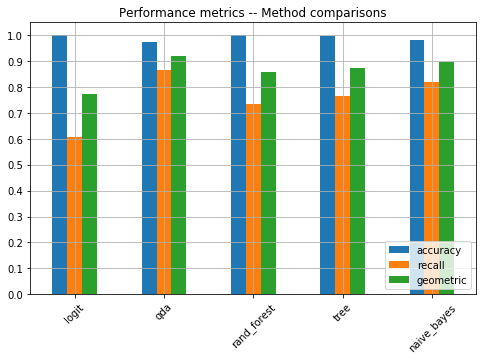

In [26]:
# df.plot.bar(figsize=(8,5),rot=0)
# plt.title('Performance metrics on raw data')
# plt.legend(loc='center right')
# plt.show()

bar_plot(df.drop(['tree_entropy']), subtitle='Method comparisons', legend_loc='lower right')

Clearly f1 is more sensitive to precision and geometric mean more sensitive to recall. We will go with the geometric mean.

#### The best 3 methods appear to be balanced logistic regression and QDA, with decision trees and vanilla logit being a little behind. KNN was poor.

### ROC and PR curves

In [21]:
qda   = QuadraticDiscriminantAnalysis().fit(reduced_data.train_x, reduced_data.train_y)
logit = LogisticRegression().fit(reduced_data.train_x, reduced_data.train_y)
nb    = GaussianNB().fit(reduced_data.train_x, reduced_data.train_y)
tree  = DecisionTreeClassifier().fit(reduced_data.train_x, reduced_data.train_y)

In [22]:
forest = RandomForestClassifier(n_estimators=10).fit(reduced_data.train_x, reduced_data.train_y)

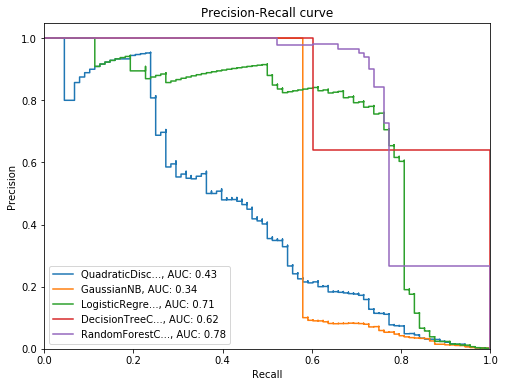

In [23]:
plt.figure(figsize=(8,6))
ax = plt.subplot(111)

plot_pr(qda,   reduced_data.test_x, reduced_data.test_y, ax=ax)
plot_pr(nb,    reduced_data.test_x, reduced_data.test_y, ax=ax)
plot_pr(logit, reduced_data.test_x, reduced_data.test_y, ax=ax)
plot_pr(tree,  reduced_data.test_x, reduced_data.test_y, ax=ax)
plot_pr(forest,  reduced_data.test_x, reduced_data.test_y, ax=ax)
plt.show()

This isn't very useful because we don't really care much about the precision of class 1 classification. A low precision is acceptable. We really want our true negative rate (tn/fp+tn) or our accurancy (which is close to TN rate) to stay high. Potentially useful to compare methods however

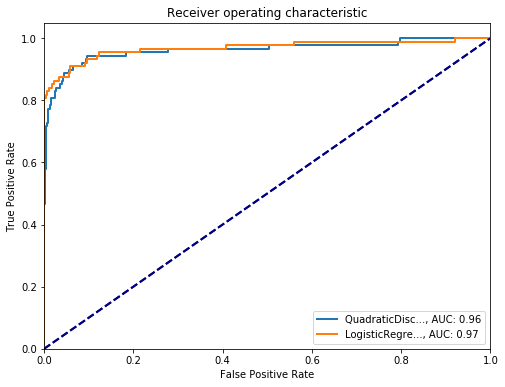

In [24]:
# plt.figure()
# ax = plt.subplot(111)

models = [qda,logit]
l = [truncate_dotdot(get_class_name(m)) for m in models]
plot_many_roc(models, l, reduced_data.test_x, reduced_data.test_y)

ROC/AUROC may still be useful, since we still want to maximize the true positive rate (TPR) and minimize the false positive rate (FPR).